In [1]:
import pystac_client
import planetary_computer
from pystac_client.stac_api_io import StacApiIO
from urllib3 import Retry

import geopandas as gpd
from odc.geo.geom import BoundingBox
import odc.geo.xr

import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize

import requests
import xml.etree.ElementTree as ET
from collections import defaultdict

import odc.stac
from odc.stac import configure_rio
from datacube.utils.aws import configure_s3_access
from distributed import LocalCluster, Client

import sys
import os

# Path to "src"
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from utils.downsample import s2_downsample_dataset_10m_to_20m

In [2]:
# Set up Dask Cluster for Parallelization
cluster = LocalCluster(n_workers=12, threads_per_worker=1, processes=False)
client = Client(cluster)
# configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
configure_rio(cloud_defaults=True, client=client) # For Planetary Computer
print(client.dashboard_link)

http://155.207.39.39:8787/status


In [3]:
def check_gri_refinement(items):
    refined_items = []
    refinement_data = []

    # Loop through items and extract `Image_Refining` flag
    for item in items:
        datastrip_metadata_url = None
        for asset_key, asset_data in items[0].assets.items():
            if "datastrip-metadata" in asset_key.lower(): # and asset_data.href.endswith(".xml"):
                # datastrip_metadata_url = planetary_computer.sign(asset_data.href)
                datastrip_metadata_url = asset_data.href
                break

        if datastrip_metadata_url:
            # print(f"Processing: {datastrip_metadata_url}")
            print(f"Processing: {item.id}") #print(f"Processing: {datastrip_metadata_url}")

            # Fetch XML content
            xml_response = requests.get(datastrip_metadata_url)
            if xml_response.status_code == 200:
                root = ET.fromstring(xml_response.content)

                # Extract Image_Refining flag
                refining_element = root.find(".//Geometric_Info/Image_Refining")
                refining_flag = refining_element.get("flag") if refining_element is not None else "Not Found"

                print(f"Image Refining Flag: {refining_flag}")

                # Store item and status in dataframe
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": refining_flag
                })

                # Append to refined_items if the flag is 'REFINED'
                if refining_flag == "REFINED":
                    refined_items.append(item)
            else:
                # print(f"Failed to fetch XML: {xml_response.status_code}")
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": "Fetch Failed"
                })
        else:
            # print("datastrip_metadata.xml not found in STAC item")
            refinement_data.append({
                "item_id": item.id,
                "refinement_status": "Metadata Not Found"
            })

    # Create a DataFrame
    df_refinement_status = pd.DataFrame(refinement_data)

    return refined_items, df_refinement_status


In [4]:
aoi = gpd.read_file('../anciliary/grid_v2.geojson').to_crs('EPSG:4326')


tile = aoi.iloc[18]
year_month = '2024-07'


tile_id = tile.tile_ids
minx, miny, maxx, maxy = tile.geometry.bounds
print(tile_id)
aoi_bbox = BoundingBox.from_xy(
    (minx, maxx),
    (miny, maxy)
)

x11_y12


In [5]:
# for i, row in aoi.iterrows():
#     print(row)

In [6]:
aoi.explore()

In [7]:
aoi_bbox.explore()

**SR#1: P01/P02. Limited Sentinel-2 Data Availability due to Cloud Cover**

This issue could arise if there are not enough images to generate monthly mosaics-especially due to winter season.
- Mitigation Measures: Develop bi-monthly image composites using Sentinel-2 imagery.
    - Back-up Measures: If bimonthly composites also fail, we will explore integrating Landsat imagery in the process or generating cloud free subsets within each AOI.


In [8]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime=year_month,
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')

Found 38 items


In [9]:
print('        Query parameters:')
print(f'            url:          {search.url}')
print(f'            client:       {search.client.id}')
print(f'            collection:   {search._parameters['collections'][0]}')
print(f'            bbox:         {search._parameters['bbox']}')
print(f'            time range:   {search._parameters['datetime']}')
print(f'            cloud cover:  0% - {search._parameters['query']['eo:cloud_cover']['lt']}%')
print(f'            nodata cover: 0% - {search._parameters['query']['s2:nodata_pixel_percentage']['lt']}%')

        Query parameters:
            url:          https://planetarycomputer.microsoft.com/api/stac/v1/search
            client:       microsoft-pc
            collection:   sentinel-2-l2a
            bbox:         (23.200099953185696, 38.52517402535158, 23.830798034177885, 39.029471826094586)
            time range:   2024-07-01T00:00:00Z/2024-07-31T23:59:59Z
            cloud cover:  0% - 70%
            nodata cover: 0% - 20%


In [ ]:
print(f'Found {len(items)} items')
print(f'Searching for GRI REFINED scenes...')
print(f'###################################')
# Regarding mis-registration (as observed in 2023 vs 2024):
# See: https://forum.step.esa.int/t/geometric-gri-refinement-in-sentinel-2-level-1c-early-images-below-pb-3-0/44024/2
# Finally, the activation of the geometric refining does not mean that the products will be always refined. 
# There are some cases (e.g. too many clouds) where the refining cannot be applied as it would not improve 
# and could degrade the geolocation of the products. This can be checked thanks to the metadata 
# Image_Data_Info/Geometric_Info/Image_Refining in the datastrip matadata file (DATASTRIP/*/MTD_DS.xml). In STAC: datastrip_metadata
# This parameter is equal to REFINED or NOT_REFINED.
#<Geometric_Info metadataLevel="Standard">
#   <RGM>COMPUTED</RGM>
#   <Image_Refining flag="REFINED">
refined_items, df_refinement_status = check_gri_refinement(items)

Found 38 items
Searching for GRI REFINED scenes...
###################################
Processing: S2A_MSIL2A_20240731T092031_R093_T34SFJ_20240731T132944
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240731T092031_R093_T34SFH_20240731T132944
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240728T090601_R050_T35SKD_20240728T152859
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240728T090601_R050_T35SKC_20240728T152859
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240728T090601_R050_T34SGJ_20240728T152859
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240728T090601_R050_T34SGH_20240728T152859
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240726T091559_R093_T34SFJ_20240726T122410
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240726T091559_R093_T34SFH_20240726T122410
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240723T090559_R050_T35SKD_20240723T120201
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240723T090559_R050_T35SK

In [ ]:
print(f'{len(refined_items)}/{len(df_refinement_status)} were refined by GRI.')

38/38 were refined by GRI.


In [ ]:
refineflag = None
if len(refined_items) == 0:
    msg = f"Tile {tile_id} | Time: {year_month}: All scenes are flagged NOT REFINED."
    print(msg)
    print(f"Tile {tile_id} | Time: {year_month}: The composite will be flagged with _NOREFINED.")
    refineflag = 'NOTREFINED'
    refined_items = items

In [ ]:
print('Looking for up to 18 cleanest images within time range')
filtered_items = []
mgrs_tiles = np.unique([i.properties['s2:mgrs_tile'] for i in refined_items])
epsgs = np.unique([i.properties['proj:epsg'] for i in refined_items])

for mgrstile in mgrs_tiles:
    item_mgrs_sorted = sorted([
        i for i in refined_items if i.properties['s2:mgrs_tile'] == str(mgrstile)
        ], key=lambda item: item.properties['eo:cloud_cover'])
    
    if len(item_mgrs_sorted) > 5:
        filtered_items.extend(item_mgrs_sorted[:5])
    else:
        filtered_items.extend(item_mgrs_sorted)
print(f"Filtered cleanest scenes: Kept {len(filtered_items)} out of {len(refined_items)} items. ")
print(f"        Included MGRS Tiles: {mgrs_tiles}")
print(f"        Included EPSG codes: {epsgs}")


Looking for up to 18 cleanest images within time range
Filtered cleanest scenes: Kept 30 out of 38 items. 
        Included MGRS Tiles: ['34SFH' '34SFJ' '34SGH' '34SGJ' '35SKC' '35SKD']
        Included EPSG codes: [32634 32635]


In [ ]:
print('Selected scenes:')
for stacitem in filtered_items:
    print(f'        {stacitem.id}')

Selected scenes:
        S2B_MSIL2A_20240716T091559_R093_T34SFH_20240716T122521
        S2A_MSIL2A_20240701T092031_R093_T34SFH_20240701T235759
        S2A_MSIL2A_20240721T092031_R093_T34SFH_20240721T162027
        S2A_MSIL2A_20240711T092031_R093_T34SFH_20240711T152305
        S2B_MSIL2A_20240706T091559_R093_T34SFH_20240706T134009
        S2B_MSIL2A_20240716T091559_R093_T34SFJ_20240716T122522
        S2A_MSIL2A_20240701T092031_R093_T34SFJ_20240701T235702
        S2A_MSIL2A_20240721T092031_R093_T34SFJ_20240721T161556
        S2A_MSIL2A_20240711T092031_R093_T34SFJ_20240711T144551
        S2B_MSIL2A_20240706T091559_R093_T34SFJ_20240706T134553
        S2B_MSIL2A_20240713T090559_R050_T34SGH_20240713T124351
        S2A_MSIL2A_20240718T090551_R050_T34SGH_20240718T135254
        S2A_MSIL2A_20240708T090601_R050_T34SGH_20240708T132042
        S2B_MSIL2A_20240723T090559_R050_T34SGH_20240723T120201
        S2A_MSIL2A_20240728T090601_R050_T34SGH_20240728T152859
        S2B_MSIL2A_20240713T090559_R05

In [50]:
def s2_downsample_dataset_10m_to_20m(ds: xr.Dataset, y="y", x="x") -> xr.Dataset:
    """
    Sen2Cor-style 10m -> 20m downsampling for all variables in a Dataset:
      - 2x2 block mean over (y, x)
      - round-half-up (+0.5) for integer vars
      - cast back to original dtype for those integer vars
    Time (and any other) dims are preserved.
    """
    if y not in ds.dims or x not in ds.dims:
        raise ValueError(f"Dataset must have '{y}' and '{x}' dims.")

    # Coarsen spatially; boundary='trim' drops the last row/col if odd-sized.
    coarsened = ds.coarsen({y: 2, x: 2}, boundary="trim").mean()

    # Round/cast back for integer-typed variables (e.g., uint16 Sentinel-2 DNs)
    out = coarsened.copy()
    for name, da in coarsened.data_vars.items():
        orig_dt = ds[name].dtype
        if np.issubdtype(orig_dt, np.integer):
            out[name] = (da + 0.5).astype(orig_dt)

    return out

In [51]:
print(f'                                 ')
print(f'Downstream STAC items from Planetary Computer')
BANDS_R10m = ['B02', 'B03', 'B04']
BANDS_R20m = ['B05', 'B07', 'B8A', 'SCL']


# Loading for each EPSG and Native RESOLUTION separatelly, then merging into a single xr.Dataset
# to to a correct downsampling
processed_epsgs = []
for EPSG in epsgs:
    processed_bands = []
    geobox = None
    for RESOLUTION in [20, 10]:
        if RESOLUTION==10:
            BANDS=BANDS_R10m
        else:
            BANDS=BANDS_R20m
        
        print('    Loading parameters:')
        print(f'        Bands: {BANDS}')
        print(f'        Spatial resolution: {RESOLUTION}')

        
        ds_bands = odc.stac.stac_load(
            filtered_items,
            bbox=aoi_bbox,
            bands=BANDS,
            chunks=dict(y=2048, x=2048),
            crs=f'EPSG:{EPSG}',  # {epsgs[0]}
            resolution=RESOLUTION,
            groupby='time', # if 'time' loads all items, retaining duplicates
            fail_on_error=True,
            # resampling={
            #     "*": RESAMPLING_ALGO,
            # },
        )
        
        if RESOLUTION==10:
            print('        Downsample 10m bands to 20m by average 2x2 binning')
            ds_bands = s2_downsample_dataset_10m_to_20m(ds_bands)
            ds_bands = ds_bands.odc.reproject(how=geobox, resampling=RESAMPLING_ALGO)
        elif RESOLUTION==20:
            ds_bands = ds_bands[['time','y','x']+list(ds_bands.data_vars)]
            geobox = ds_bands.odc.geobox
        
        processed_bands.append(ds_bands)
        
    xmin = xmax = ymin = ymax = None
    for da in processed_bands:
        xmin = da.x.min().item() if xmin is None or da.x.min() > xmin else xmin
        xmax = da.x.max().item() if xmax is None or da.x.max() < xmax else xmax
        ymin = da.y.min().item() if ymin is None or da.y.min() > ymin else ymin
        ymax = da.y.max().item() if ymax is None or da.y.max() < ymax else ymax

    merge_bands = []
    for da in processed_bands:
        merge_bands.append(da.sel(x=slice(xmin, xmax), y=slice(ymax,ymin)))
    
    ds_epsg = xr.merge(
        merge_bands,
        compat="no_conflicts",
        combine_attrs="drop_conflicts",
        join="inner"
    )
    
    RESAMPLING_ALGO = "bilinear"
    ds_epsg = ds_epsg.odc.reproject(how='EPSG:3035', resampling=RESAMPLING_ALGO)
    
    processed_epsgs.append(ds_epsg)
    

                                 
Downstream STAC items from Planetary Computer
    Loading parameters:
        Bands: ['B05', 'B07', 'B8A', 'SCL']
        Spatial resolution: 20
    Loading parameters:
        Bands: ['B02', 'B03', 'B04']
        Spatial resolution: 10
        Downsample 10m bands to 20m by average 2x2 binning
    Loading parameters:
        Bands: ['B05', 'B07', 'B8A', 'SCL']
        Spatial resolution: 20
    Loading parameters:
        Bands: ['B02', 'B03', 'B04']
        Spatial resolution: 10
        Downsample 10m bands to 20m by average 2x2 binning


In [53]:
chunks = {"time": 1, "y": 2048, "x": 2048}
for i, da in enumerate(processed_epsgs):
    processed_epsgs[i] = processed_epsgs[i].chunk(chunks)

In [55]:
from rioxarray.merge import merge_datasets
mosaic = merge_datasets(processed_epsgs)

RasterioIOError: Read failed. See previous exception for details.

In [34]:
for dataset in processed_bands:
    print(dataset.odc.geobox.resolution)

Resolution(x=20, y=-20)
Resolution(x=20, y=-20)


In [79]:
xmin = xmax = ymin = ymax = None
for da in processed_bands:
    xmin = da.x.min().item() if xmin is None or da.x.min() > xmin else xmin
    xmax = da.x.max().item() if xmax is None or da.x.max() < xmax else xmax
    ymin = da.y.min().item() if ymin is None or da.y.min() > ymin else ymin
    ymax = da.y.max().item() if ymax is None or da.y.max() < ymax else ymax

merge_bands = []
for da in processed_bands:
    merge_bands.append(da.sel(x=slice(xmin, xmax), y=slice(ymax,ymin)))

In [83]:
xr.merge(merge_bands,
                      compat="override",
                      combine_attrs="drop_conflicts",
                      join="exact")

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 11, y: 3445, x: 3366)
Coordinates:
  * time         (time) datetime64[ns] 88B 2024-07-01T09:20:31.024000 ... 202...
  * y            (y) float64 28kB 1.882e+06 1.882e+06 ... 1.814e+06 1.814e+06
  * x            (x) float64 27kB 5.462e+06 5.462e+06 ... 5.53e+06 5.53e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (time, y, x) float32 510MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) float32 510MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) float32 510MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05          (time, y, x) float32 510MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    B07          (time, y, x) float32 510MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    B8A          (time, y, x) float32 510MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    SCL          (time, y, x) float32 510MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>

In [63]:
merge_datasets(processed_bands)

KeyError: "No variable named 'B02'. Variables on the dataset include ['time', 'y', 'x', 'spatial_ref', 'B05', 'B07', 'B8A', 'SCL']"

In [ ]:
combined = xr.concat(aligned, dim="time").sortby("time")

In [5]:
from rioxarray.merge import merge_datasets

In [27]:
xr.merge(processed_bands)

c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\dask\array\core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\dask\array\core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\dask\array\core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\dask\array\core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\distributed\client.py:3357: UserWarning: Sending large graph of size 2.64 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also htt

KeyboardInterrupt: 

In [ ]:
ds_cube = odc.stac.stac_load(
        items,
        bbox=aoi_bbox,
        # bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL'],
        bands=['B02', 'B03', 'B04', 'B05', 'B07', 'B8A', 'SCL'],
        chunks=dict(y=1024, x=1024),
        # crs=f'epsg:{epsgs[0]}', # Equi7Grid European EPSG (https://github.com/TUW-GEO/Equi7Grid)
        crs=f'epsg:3035',
        resolution=20,
        groupby='time', # if 'time' loads all items, retaining duplicates
        fail_on_error=True,
        resampling={
            "*": "average",
        },
    )
ds_cube

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 3063, x: 2995, time: 7)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B07          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [ ]:
a = ['B02', 'B03', 'B04', 'B05', 'B07', 'B08', 'B8A', 'SCL']
a.remove('SCL')
a

['B02', 'B03', 'B04', 'B05', 'B07', 'B08', 'B8A']

In [11]:
# - 0: no data
# - 1: saturated or defective
# - 2: dark area pixels
# - 3: cloud shadows
# - 4: vegetation
# - 5: bare soils
# - 6: water
# - 7: unclassified
# - 8: cloud medium probability
# - 9: cloud high probability
# - 10: thin cirrus
# - 11: snow or ice
invalid_scl_values = [3, 7, 8, 9, 10, 11]
cloud_binary_mask = ds_cube.SCL.isin(invalid_scl_values)

# bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
bands=['B02', 'B03', 'B04', 'B05', 'B07', 'B8A']
ds_cube_cf = ds_cube[bands].where(~cloud_binary_mask, 0).astype('uint16')
ds_cube_cf

<xarray.Dataset> Size: 771MB
Dimensions:      (time: 7, y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B07          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [12]:
import pandas as pd
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Baseline-Change
mask = ds_cube_cf.time > pd.Timestamp('2022-01-25')
ds_cube_cf = ds_cube_cf.where(~mask, ds_cube_cf - 1000)

In [13]:
print('Clip range')
ds_cube_cf = ds_cube_cf.where(ds_cube_cf > 0, np.nan)
ds_cube_cf = ds_cube_cf.where(ds_cube_cf<=10000)

Clip range


In [14]:
sis = ['evi', 'ndvi', 'psri2']

ds_cube_cf['evi'] = 2.5 * ((ds_cube_cf.B8A - ds_cube_cf.B04)/10000) / ((ds_cube_cf.B8A/10000 + 6*ds_cube_cf.B04/10000 - 7.5*ds_cube_cf.B02/10000) + 1)
ds_cube_cf['ndvi'] = ((ds_cube_cf.B05 - ds_cube_cf.B03) / ds_cube_cf.B07).astype('float32')
ds_cube_cf['psri2'] = ((ds_cube_cf.B8A - ds_cube_cf.B04) / (ds_cube_cf.B8A + ds_cube_cf.B04)).astype('float32')

print('Clip to typical value range')
for si in sis:
    if si in ['NGRDI', 'NDWI', 'ndvi', 'NDVI705', 'NDII', 'evi']:
        ds_cube_cf[si] = ds_cube_cf[si].where((ds_cube_cf[si]>=-1)&(ds_cube_cf[si]<=1))
    else:
        ds_cube_cf[si] = ds_cube_cf[si].where((ds_cube_cf[si]>=-1)&(ds_cube_cf[si]<=4))

Clip to typical value range


In [15]:
vars = bands+sis
median_composite = ds_cube_cf[vars].median(dim='time').astype('float32').compute()

for band in bands:
    dtype = 'uint16'
    nodata = np.iinfo(np.uint16).min #0
    median_composite[band] = median_composite[band].astype(dtype)
    median_composite[band] = median_composite[band].rio.write_nodata(nodata, inplace=True)
    median_composite[band].encoding.update({"dtype": dtype})
    
for si in sis:  
    scale = 1000 
    dtype = 'int16'
    nodata = np.iinfo(np.int16).min #-32768
    median_composite[si] = (median_composite[si]*scale).round()
    median_composite[si] = median_composite[si].fillna(nodata).astype(dtype)
    median_composite[si] = median_composite[si].rio.write_nodata(nodata, inplace=True)
    median_composite[si].encoding.update({"dtype": dtype})
    # median_composite[si].encoding["scale_factor"] = 1/scale

median_composite

<xarray.Dataset> Size: 165MB
Dimensions:      (y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (y, x) uint16 18MB 219 222 231 231 235 ... 233 222 220 225 208
    B03          (y, x) uint16 18MB 101 103 103 105 104 ... 140 120 127 130 117
    B04          (y, x) uint16 18MB 44 62 45 43 51 55 31 ... 76 74 64 74 70 65
    B05          (y, x) uint16 18MB 38 40 40 47 50 41 28 ... 82 85 73 78 73 61
    B07          (y, x) uint16 18MB 37 45 17 23 29 25 25 ... 73 69 65 69 53 51
    B8A          (y, x) uint16 18MB 29 33 32 24 21 30 27 ... 67 79 73 58 36 39
    evi          (y, x) int16 18MB -5 -8 -5 -7 -9 -6 -5 -4 ... 0 -3 0 3 0 -5 0
    ndvi         (y, x) int16 18MB -32768 -904 -857 -827 ... -458 -552 -432 -496
    psri2        (y, x) int16 18MB -234 -216 -153 -242 -404 ... 0 66 -4 -100 -4

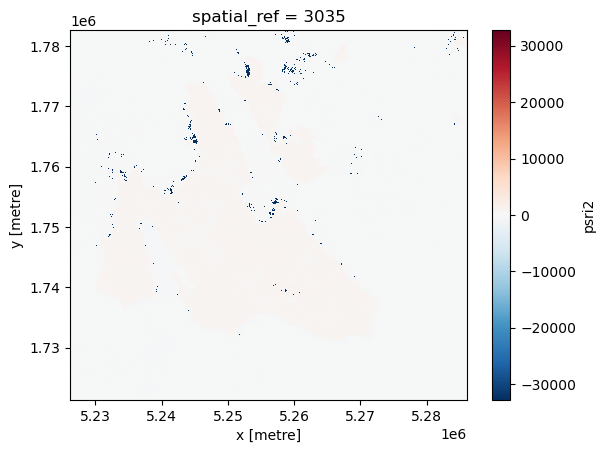

In [17]:
median_composite.psri2.plot()

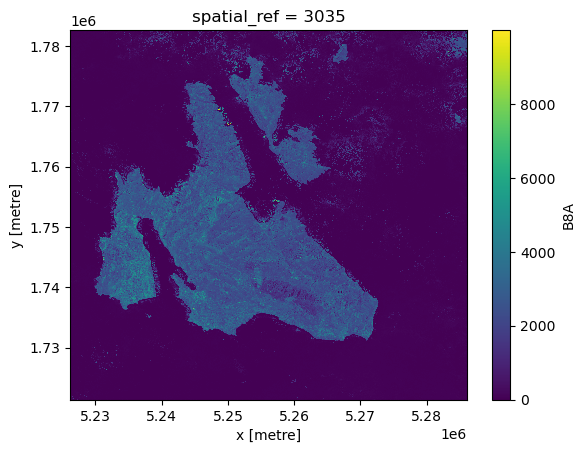

In [30]:
median_composite.B8A.plot()

In [18]:
from pathlib import Path
def mkdir(path: str):
    Path(path).mkdir(parents=True, exist_ok=True)

In [19]:
tile = aoi.iloc[7].tile_ids

In [20]:
yyyy = ds_cube_cf.isel(time=0).time.dt.year.item()
mm1 = ds_cube_cf.isel(time=0).time.dt.month.item()
mm2 = ds_cube_cf.isel(time=-1).time.dt.month.item()
dd1 = ds_cube_cf.isel(time=0).time.dt.day.item()
dd2 = ds_cube_cf.isel(time=-1).time.dt.day.item()
median_composite.attrs['dtr:start_datetime']=f'{yyyy}-{mm1:02d}-{dd1:02d}'
median_composite.attrs['dtr:end_datetime']=f'{yyyy}-{mm2:02d}-{dd2:02d}'
median_composite.attrs['odc:region_code']=tile

In [21]:
NASROOT='//nas-rs.topo.auth.gr/Latomeia/DROUGHT'
FOLDER=f'COMPOS/{yyyy}/{mm1}/{tile}'
DATASET= f'S2L2A_medcomp_{tile}_{yyyy}{mm1:02d}'
PRODUCT_NAME = 'composites'
collection_path = f"{NASROOT}/{FOLDER}"
mkdir(collection_path)
eo3_path = f'{collection_path}/{DATASET}.odc-metadata.yaml'
stac_path = f'{collection_path}/{DATASET}.stac-metadata.json'
datetime_list = [
    ds_cube_cf.isel(time=0).time.dt.year.item(),
    ds_cube_cf.isel(time=0).time.dt.month.item(),
    1
]

In [22]:
median_composite

<xarray.Dataset> Size: 165MB
Dimensions:      (y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (y, x) uint16 18MB 219 222 231 231 235 ... 233 222 220 225 208
    B03          (y, x) uint16 18MB 101 103 103 105 104 ... 140 120 127 130 117
    B04          (y, x) uint16 18MB 44 62 45 43 51 55 31 ... 76 74 64 74 70 65
    B05          (y, x) uint16 18MB 38 40 40 47 50 41 28 ... 82 85 73 78 73 61
    B07          (y, x) uint16 18MB 37 45 17 23 29 25 25 ... 73 69 65 69 53 51
    B8A          (y, x) uint16 18MB 29 33 32 24 21 30 27 ... 67 79 73 58 36 39
    evi          (y, x) int16 18MB -5 -8 -5 -7 -9 -6 -5 -4 ... 0 -3 0 3 0 -5 0
    ndvi         (y, x) int16 18MB -32768 -904 -857 -827 ... -458 -552 -432 -496
    psri2        (y, x) int16 18MB -234 -216 -153 -242 -404 ... 0 66 -4 -100 -4
Attributes:
    dtr:start_datetime:  2024-01-01
    dtr:end_datetime:    2024-02-20
    odc:region_code:     x06_y10

In [24]:
name_measurements = []
for var in list(median_composite.data_vars):
    print(var)
        
    file_path = f'{collection_path}/{DATASET}_{var}.tif'
    
    median_composite[var].rio.to_raster(raster_path=file_path, 
                                       driver='COG',
                                       dtype=str(median_composite[var].dtype),
                                       windowed=True,
                                       )
    name_measurements.append(file_path)

B02
B03
B04
B05
B07
B8A
evi
ndvi
psri2


In [25]:
name_measurements

['//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B02.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B03.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B04.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B05.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B07.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_B8A.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_evi.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_ndvi.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401_psri2.tif']

In [26]:
import rasterio as rio
from eodatasets3 import DatasetPrepare, DatasetDoc, ValidDataMethod
from eodatasets3.model import ProductDoc, AccessoryDoc
from eodatasets3 import serialise
from eodatasets3.stac import to_stac_item

from shapely import Polygon

import datetime
import pandas as pd
from pathlib import Path

In [27]:
import datacube
dc = datacube.Datacube(app='test', env='drought')

In [28]:
nas_root=NASROOT
set_range=True
lineage_path=False
version=1
product_family='ard'
product_name=PRODUCT_NAME
dataset_name=DATASET
xr_cube = median_composite.copy()

y,m,d = datetime_list

with DatasetPrepare(
    dataset_location=Path(collection_path),                 #  A string location is expected to be a URL or VSI path.
    metadata_path=Path(f'{collection_path}/{dataset_name}.odc-metadata.yaml'), #  A string location is expected to be a URL or VSI path.
    allow_absolute_paths=False,
    naming_conventions="default"
) as preparer:

    preparer.valid_data_method = ValidDataMethod.bounds

    preparer.product_name = product_name
    preparer.product_family = product_family
    preparer.product_maturity = "stable"
    preparer.dataset_version = str(version) # if used without product_name then 'product': {'name': 'productname_1'}

    preparer.datetime = datetime.datetime(y,m,d)
    if set_range:
        preparer.datetime_range = [
            datetime.datetime(int(xr_cube.attrs['dtr:start_datetime'][0:4]),
                              int(xr_cube.attrs['dtr:start_datetime'][5:7]),
                              int(xr_cube.attrs['dtr:start_datetime'][8:10]),
                              0,0,0),
            datetime.datetime(int(xr_cube.attrs['dtr:end_datetime'][0:4]),
                              int(xr_cube.attrs['dtr:end_datetime'][5:7]),
                              int(xr_cube.attrs['dtr:end_datetime'][8:10]),
                              23,59,59)]
    preparer.processed_now()

    preparer.properties["odc:region_code"] = xr_cube.attrs['odc:region_code']
    preparer.properties["odc:file_format"] = "GeoTIFF"
    preparer.properties["odc:processing_datetime"] = datetime.datetime.now().isoformat()

    if hasattr(xr_cube, 'eo:instrument"'):
        preparer.properties["eo:instrument"] = xr_cube.attrs['eo:instrument']
    if hasattr(xr_cube, 'eo:platform"'):
        preparer.properties["eo:platform"] = xr_cube.attrs['eo:platform']
    preparer.properties["eo:gsd"] = int(abs(xr_cube.odc.geobox.resolution.x))


    if lineage_path:
        preparer.add_accessory_file("lineage", lineage_path) # For composites, path to json with S2 IDs

    # if uuid_lineage:
    #     preparer.note_source_datasets(product_lineage, uuid_lineage) # As in ("ard", metadata["id"]), UUIDs from datacube schema

    polygon_geometry = Polygon(xr_cube.odc.geobox.boundingbox.polygon.boundary.coords)
    preparer.geometry = polygon_geometry

    bands = list(dc.list_measurements().loc[product_name].name.values)
    for name, path in zip(bands, name_measurements):
        preparer.note_measurement(name, str(Path(path).resolve()), relative_to_dataset_location=False) # else: (name, f'{granule_dir}/{path}', relative_to_dataset_location=False)

    eo3_doc = preparer.to_dataset_doc()

    crs, grid_docs, measurement_docs = preparer._measurements.as_geo_docs()

    eo3 = DatasetDoc(
        id=preparer.dataset_id,
        label=preparer.label,
        product=ProductDoc(
            name=preparer.names.product_name, href=preparer.names.product_uri
        ),
        crs=preparer._crs_str(crs) if crs is not None else None,
        geometry=polygon_geometry,
        grids=grid_docs,
        properties=preparer.properties,
        accessories={
            name: AccessoryDoc(path, name=name)
            for name, path in preparer._accessories.items()
        },
        measurements=measurement_docs,
        # lineage=preparer._lineage, # Preparer does not have _lineage
    )

    for measurement in eo3.measurements.values():
        if measurement.grid is None:
            measurement.grid = 'default'

stac_path = f'{collection_path}/{dataset_name}.stac-metadata.json'
stac_doc = to_stac_item(dataset=eo3, stac_item_destination_url=stac_path, collection_url=f'file://{collection_path}')


In [29]:
import json
serialise.to_path(Path(eo3_path), eo3_doc)
with open(stac_path, 'w') as json_file:
    json.dump(stac_doc, json_file, indent=4, default=False)

In [30]:
from datacube.index.hl import Doc2Dataset
WORKING_ON_CLOUD=False
uri = eo3_path if WORKING_ON_CLOUD else f"file:///{eo3_path}"

resolver = Doc2Dataset(dc.index)
dataset_tobe_indexed, err  = resolver(doc_in=serialise.to_doc(eo3_doc), uri=uri)

In [31]:
err

In [32]:
dc.index.datasets.add(dataset=dataset_tobe_indexed, with_lineage=False)

Dataset <id=dea9820b-1f87-4f20-b860-a6b1b8fb16dc product=composites location=file://///nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/1/x06_y10/S2L2A_medcomp_x06_y10_202401.odc-metadata.yaml>

# Test loading

In [33]:
new = dc.load(
    product='composites',
)

In [35]:
new

<xarray.Dataset> Size: 165MB
Dimensions:      (time: 1, y: 3063, x: 2995)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-26T11:59:59.500000
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (time, y, x) uint16 18MB 219 222 231 231 ... 222 220 225 208
    B03          (time, y, x) uint16 18MB 101 103 103 105 ... 120 127 130 117
    B04          (time, y, x) uint16 18MB 44 62 45 43 51 55 ... 74 64 74 70 65
    B05          (time, y, x) uint16 18MB 38 40 40 47 50 41 ... 85 73 78 73 61
    B07          (time, y, x) uint16 18MB 37 45 17 23 29 25 ... 69 65 69 53 51
    B8A          (time, y, x) uint16 18MB 29 33 32 24 21 30 ... 79 73 58 36 39
    ndvi         (time, y, x) int16 18MB -5 -8 -5 -7 -9 -6 -5 ... -3 0 3 0 -5 0
    evi          (time, y, x) int16 18MB -32768 -904 -857 ... -552 -432 -496
    psri2        (time, y, x) int16 18MB -234 -216 -153 -242 ... 66 -4 -100 -4
Attributes:
    crs:           EPSG:3035
    grid_mapping:  spatial_ref

In [34]:
median_composite

<xarray.Dataset> Size: 165MB
Dimensions:      (y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (y, x) uint16 18MB 219 222 231 231 235 ... 233 222 220 225 208
    B03          (y, x) uint16 18MB 101 103 103 105 104 ... 140 120 127 130 117
    B04          (y, x) uint16 18MB 44 62 45 43 51 55 31 ... 76 74 64 74 70 65
    B05          (y, x) uint16 18MB 38 40 40 47 50 41 28 ... 82 85 73 78 73 61
    B07          (y, x) uint16 18MB 37 45 17 23 29 25 25 ... 73 69 65 69 53 51
    B8A          (y, x) uint16 18MB 29 33 32 24 21 30 27 ... 67 79 73 58 36 39
    evi          (y, x) int16 18MB -5 -8 -5 -7 -9 -6 -5 -4 ... 0 -3 0 3 0 -5 0
    ndvi         (y, x) int16 18MB -32768 -904 -857 -827 ... -458 -552 -432 -496
    psri2        (y, x) int16 18MB -234 -216 -153 -242 -404 ... 0 66 -4 -100 -4
Attributes:
    dtr:start_datetime:  2024-01-01
    dtr:end_datetime:    2024-02-20
    odc:region_code:     x06_y10

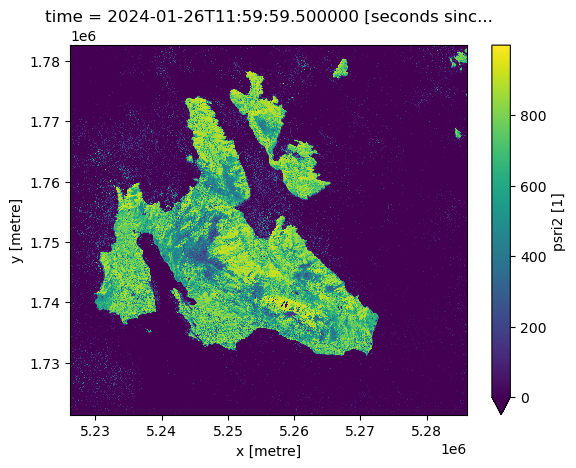

In [40]:
new.psri2.plot(vmin=0)